# Digital Musicology (DH-401)
## Assignment 1: Discovering meter
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

Rough outline
## 0. Data preparation
## 1. From musical score to metrical weights
## 2. From metrical weights to periodicities
## 3. From periodicities to time signature
## 4. Accuracy of classification

#TODO:
- consider grace notes as normal notes (replace 'duration' with 'nominal_duration',
because 'duration' is empty for them) -> check before/after impact to classification
- we also need to sum up durations of tied notes based on piece and staff and voice
- use appropriate method to extract frequencies/periodicities
- use appropriate method to infer time signature
- create simple classification accuracy measure with Ground Truth

In [160]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt

## 0. Data preparation

In [161]:
# This is the time unit of 'global_onset' used in the dataset
time_unit = 1/4

meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
df = meter_dataset[['piece','timesig','global_onset', 'staff', 'voice', 'duration', 'nominal_duration', 'tied', 'gracenote']]

# Ignore gracenotes for now
df = df[df['gracenote'].isna()]

# df['beat_unit'] = [fractions.Fraction(1/int(timesig.split('/')[1])) for timesig in df['timesig']]

## 1. From musical score to metrical weights

Smallest note length in dataset: 1/32


,piece,timesig,global_onset,staff,voice,duration,nominal_duration,tied,gracenote
269850,K309-1,4/4,0,1,1,1/2,1/2,NaN,NaN
269852,K309-1,4/4,2,1,1,1/2,1/2,NaN,NaN
269854,K309-1,4/4,4,1,1,3/8,1/4,NaN,NaN
269856,K309-1,4/4,11/2,1,1,1/16,1/16,NaN,NaN
269858,K309-1,4/4,23/4,1,1,1/16,1/16,NaN,NaN
...,...,...,...,...,...,...,...,...,...
272217,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272218,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272221,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN
272222,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN


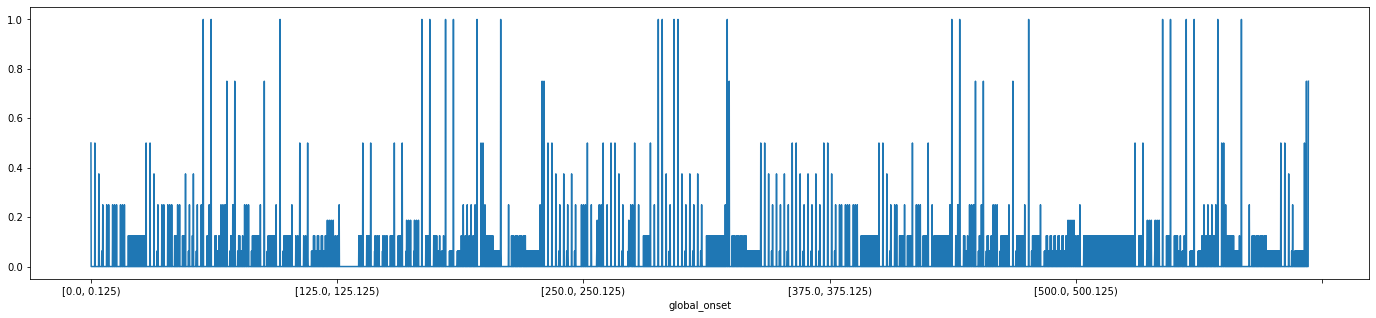

In [162]:
# Select one piece and staff (time signature may change per staff)
one_piece_staff = df[(df['piece'] == 'K309-1') & (df['staff'] == 1)]

# To fine-tune sampling, get minimum note duration among all notes in the piece/staff
min_note = float(one_piece_staff['duration'].min())
print("Smallest note length in dataset:", fractions.Fraction(min_note))

sampling_period = min_note/time_unit
total_piece_duration = one_piece_staff['global_onset'].max()

# Partition the global_onsets in bins
bins = np.arange(0, (total_piece_duration+sampling_period+1e-10), sampling_period)
binned_onsets = pd.cut(one_piece_staff['global_onset'], bins, right = False)

# Compute the sum of durations of all events with onsets in each bin
binned_durations = one_piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)
binned_durations.plot(figsize=(24,5));

one_piece_staff

In [163]:
%%time

# For all pieces and staves (This operation takes around 2-3 minutes on our computer)

# Create dictionaries of total piece durations and smallest notes in each piece/staff
total_piece_durations_df = df.groupby(['piece','staff'])['global_onset'].max().apply(float)
minimum_note_durations_df = df.groupby(['piece','staff'])['duration'].min().apply(float)
total_piece_durations = total_piece_durations_df.to_dict()
minimum_note_durations = minimum_note_durations_df.to_dict()

binned_durations = {}
for key,value in total_piece_durations.items():
    piece_staff = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]

    min_note = minimum_note_durations[key]
    sampling_period = min_note/time_unit

    bins = np.arange(0, (value+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_staff['global_onset'], bins, right = False)
    binned_durations[key] = piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 1min 40s, sys: 2.53 s, total: 1min 43s
Wall time: 1min 57s


Metrical weights of Piece: n12op127_03, Staff: 2


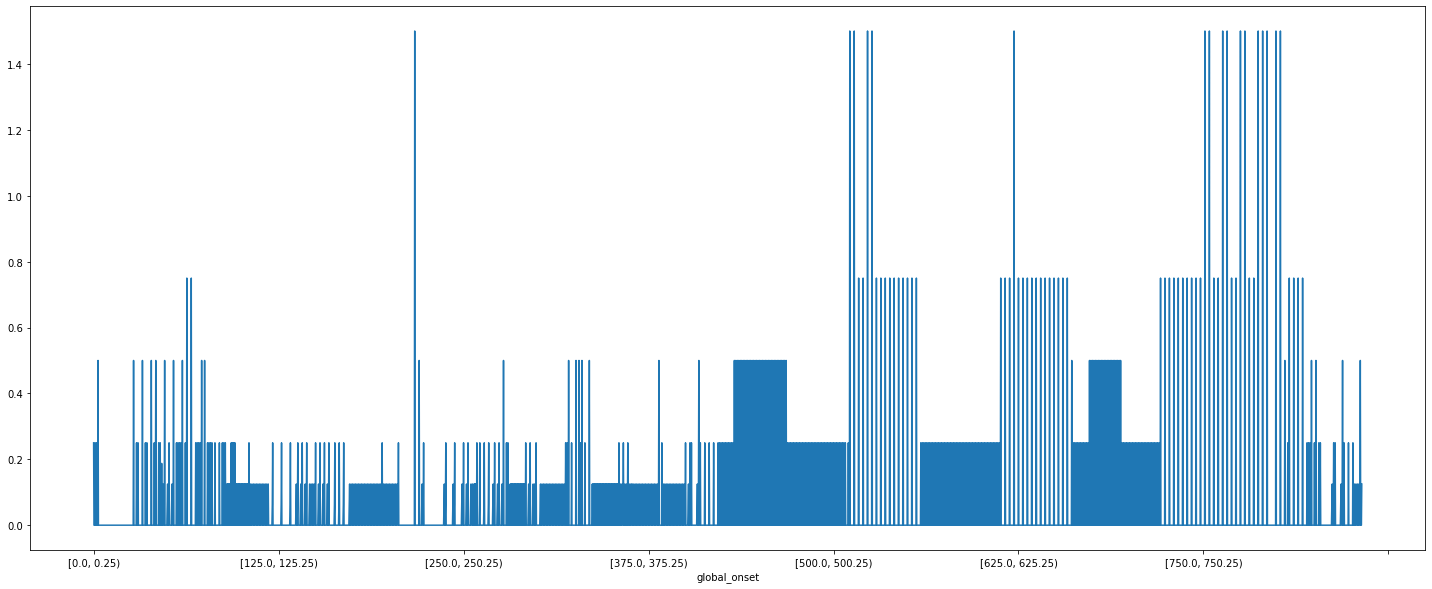

In [166]:
# Now we can print the metrical weights of a random piece + staff
random_piece_staff = df[['piece', 'staff']].sample(n=1).to_records(index=False)
key = tuple(random_piece_staff[0])
print("Metrical weights of Piece: {piece}, Staff: {staff}".format(piece = key[0], staff = key[1]))

binned_durations[key].plot(figsize=(25,10));

## 2. From metrical weights to periodicities